## Wen Cui, Tianyu Yang

In [14]:
from keras.layers import Input, Dense, Conv2D,MaxPooling2D,UpSampling2D,Dropout,Flatten
from keras.models import Model, Sequential
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras import backend as K

def extract_layer_output(model, layer_num):
    return K.function([model.input] + [K.learning_phase()], [model.layers[layer_num].output])

## 1 Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.
Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we’ve used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.
An example to guide your thinking can be found toward the bottom of this post https://blog.keras.io/building-autoencoders-in-keras.html.
After training your network, visualize some examples of input images and their decoded reconstruction.

In [7]:
# load fashion mnist data
(X_train,y_train), (X_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
labels =['t-shirt', 'trouser', 'pullover', 'dress', 'coat','snadal', 'shirt', 'sneaker','bag','ankle boot']
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
print(X_train.shape)

(60000, 28, 28, 1)


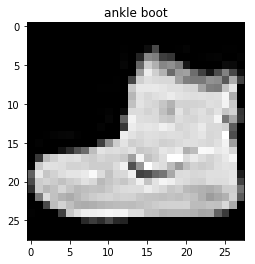

In [8]:
plt.imshow(X_train[0,:,:].reshape(28,28),cmap='gray')
plt.title(labels[y_train[0]])
plt.show()


In [9]:
#construct encoder
c_auto  = Sequential()
# encoding
c_auto.add(Conv2D(filters = 32,kernel_size= (3,3), activation= 'relu', padding='same',strides=(1,1), input_shape = (28,28,1)))
c_auto.add(MaxPooling2D((2,2), padding ='same'))
c_auto.add(Conv2D(filters = 32,kernel_size= (3,3), activation= 'relu', padding='same',strides=(1,1)))
c_auto.add(MaxPooling2D((2,2), padding = 'same'))
c_auto.add(Conv2D(filters = 32,kernel_size= (3,3), activation= 'relu', padding='same',strides=(1,1)))
c_auto.add(MaxPooling2D((2,2), padding = 'same'))

# decoding
c_auto.add(Conv2D(filters =8,kernel_size= (3,3), activation= 'relu', padding='same',strides=(1,1)))
c_auto.add(UpSampling2D((2,2)))
c_auto.add(Conv2D(filters = 8,kernel_size= (3,3), activation= 'relu', padding='same',strides=(1,1)))
c_auto.add(UpSampling2D((2,2)))
c_auto.add(Conv2D(filters = 16,kernel_size= (3,3), activation= 'relu',strides=(1,1)))
c_auto.add(UpSampling2D((2,2)))
c_auto.add(Conv2D(filters = 1,kernel_size= (3,3), activation= 'sigmoid', padding='same'))

c_auto.compile(optimizer = 'adadelta', loss ='binary_crossentropy')
c_auto.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           2312      
__________

In [10]:
# model training
c_auto.fit(X_train, X_train, epochs = 3, batch_size = 256, validation_split=0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/3
42000/42000 [==============================] - 76s 2ms/step - loss: -1131.9942 - val_loss: -1155.7335
Epoch 2/3
42000/42000 [==============================] - 76s 2ms/step - loss: -1149.0023 - val_loss: -1156.7810
Epoch 3/3
42000/42000 [==============================] - 74s 2ms/step - loss: -1149.7179 - val_loss: -1157.4837


In [11]:
f=extract_layer_output(c_auto, 5)
decodedpic= c_auto.predict(X_test[:10,:])
encodedpic =f([X_test[:10,:]])[0]

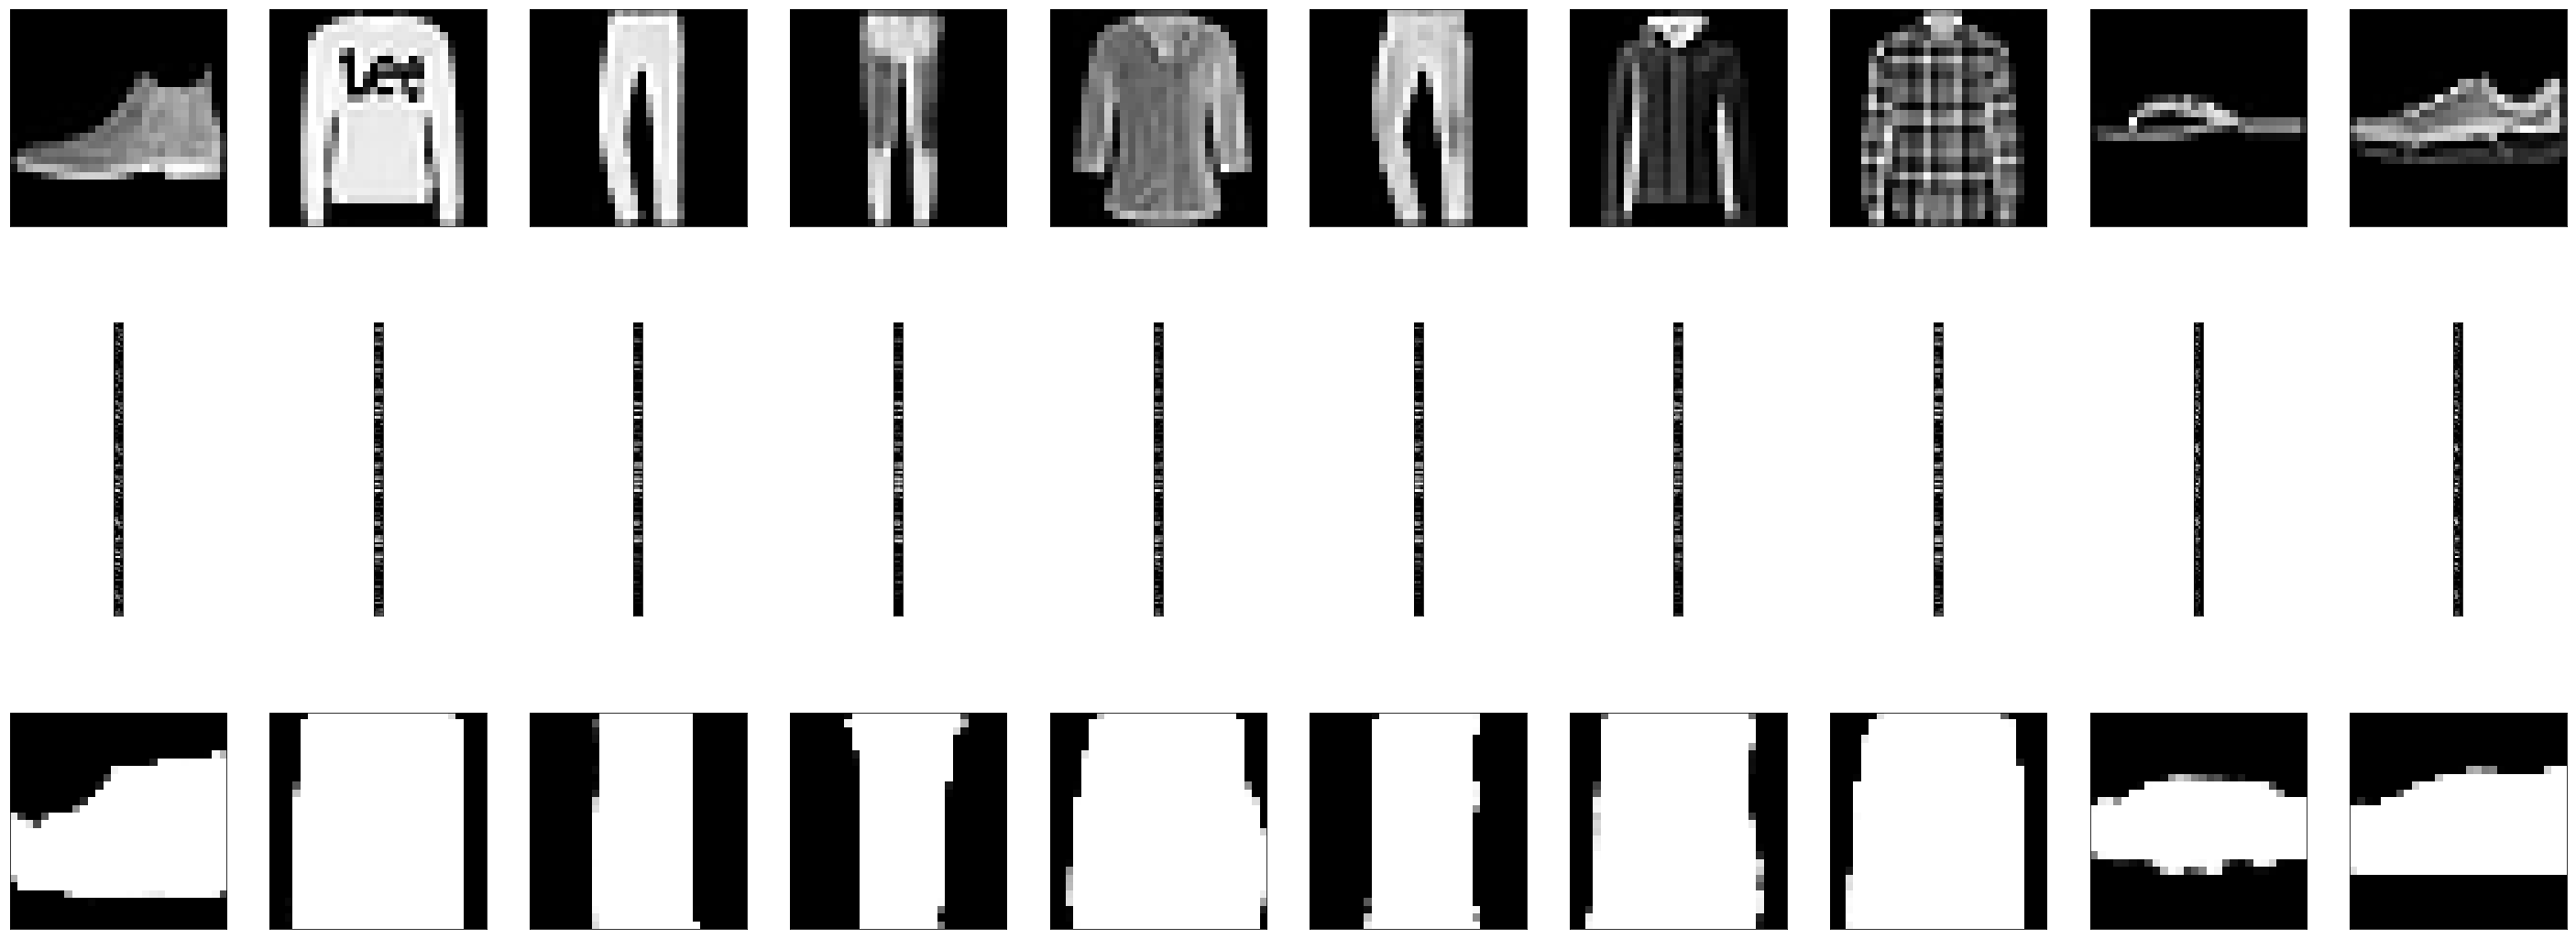

In [12]:
plt.figure(figsize=(50,20))
for i in range(10):
    
    #original
    ax = plt.subplot(3,10,i+1)
    plt.imshow(X_test[i,:].reshape(28,28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #encoded
    ax = plt.subplot(3,10,i+10+1)
    plt.imshow(encodedpic[i].reshape(4, 4 * 32).T,cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #decoded
    ax = plt.subplot(3,10,i+20+1)
    plt.imshow(decodedpic[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2 Image Classification

We’ll continue to use the Fashion MNIST dataset and build a deep convolutional network for classification.

### 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model’s performance on training set and test set.


In [170]:
cnn = Sequential()
cnn.add(Conv2D(filters =64 ,kernel_size=(4, 4), 
                 activation='relu', strides=(1, 1), 
                 padding='same',
                 input_shape=(28,28,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(filters = 64,kernel_size=(4, 4), 
                 activation='relu', strides=(1, 1), 
                 padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))
print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_158 (Conv2D)          (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 14, 14, 64)        65600     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3136)              0         
__________

In [171]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
cnn.compile(loss = 'categorical_crossentropy',
            optimizer='adam',
            metrics = ['accuracy'])
cnn.fit(X_train, Y_train,
          epochs=4,
          batch_size=128,
        validation_split = 0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/4
42000/42000 [==============================] - 57s 1ms/step - loss: 4.8642 - acc: 0.4671 - val_loss: 0.5461 - val_acc: 0.7930
Epoch 2/4
42000/42000 [==============================] - 56s 1ms/step - loss: 0.7279 - acc: 0.7179 - val_loss: 0.4223 - val_acc: 0.8456
Epoch 3/4
42000/42000 [==============================] - 55s 1ms/step - loss: 0.5881 - acc: 0.7855 - val_loss: 0.3618 - val_acc: 0.8669
Epoch 4/4
42000/42000 [==============================] - 55s 1ms/step - loss: 0.5130 - acc: 0.8116 - val_loss: 0.3459 - val_acc: 0.8777


In [172]:
y_pred = cnn.predict_classes(X_test)

In [176]:
# accuracy on test set
(y_pred == y_test).sum()/len(y_test)

0.8727

The network contains two convolution layers each with 64 3 by 3 filters, striding 1 by 1. Each convolution layer is followed by a max pooling layer with size 2 by 2. Drop out is applied on the last max pooling layer. After, the network contains two dense layers with 64 and 10 neurons respectively. Drop out is applied on both layer. Relu activation is applied on all but last layer, where softmax is used.<br><br>
The model is trained for 4 epochs with 30% validation. Model accuracy is around 87% for both the validation and test set.

### 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model’s performance on training set and test set.


In [291]:
from keras.applications import ResNet50
from scipy.misc import imresize
from keras.preprocessing.image import img_to_array, array_to_img



In [301]:
resX_train = X_train
resX_test = X_test
resX_train = np.c_[X_train,X_train,X_train]
resX_test = np.c_[X_test, X_test,X_test]
resX_train = np.asarray([img_to_array(array_to_img(im, scale  = False).resize((50,50))) for im in resX_train])
resX_test = np.asarray([img_to_array(array_to_img(im, scale  = False).resize((50,50))) for im in resX_test])


In [306]:
conv_base = ResNet50(weights="imagenet",include_top=False,input_shape=(50,50,3))
t_model = Sequential()
t_model.add(conv_base)
t_model.add(Flatten())
t_model.add(Dense(256, activation="relu"))
t_model.add(Dropout(0.5))
t_model.add(Dense(10, activation="softmax"))   
conv_base.trainable = False
t_model.summary()


/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_23 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                2570      
Total params: 25,687,690
Trainable params: 2,099,978
Non-trainable params: 23,587,712
_________________________________________________________________


In [307]:
t_model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["acc"])




In [308]:
t_model.fit(resX_train, Y_train,
          epochs=4,
          batch_size=128,
        validation_split = 0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/4
42000/42000 [==============================] - 351s 8ms/step - loss: 0.6989 - acc: 0.7704 - val_loss: 1.9905 - val_acc: 0.3883
Epoch 2/4
42000/42000 [==============================] - 339s 8ms/step - loss: 0.4652 - acc: 0.8351 - val_loss: 1.9881 - val_acc: 0.4084
Epoch 3/4
42000/42000 [==============================] - 339s 8ms/step - loss: 0.3949 - acc: 0.8590 - val_loss: 1.8540 - val_acc: 0.4594
Epoch 4/4
42000/42000 [==============================] - 338s 8ms/step - loss: 0.3478 - acc: 0.8732 - val_loss: 1.7040 - val_acc: 0.4914


In [315]:
sum(t_model.predict_classes(resX_test) == y_test)/len(y_test)

0.4932

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


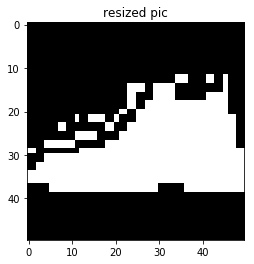

In [316]:
plt.imshow(resX_test[0])
plt.title('resized pic')
plt.show()

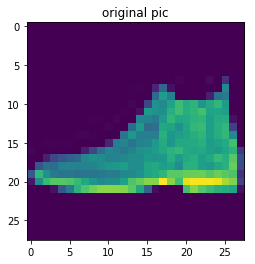

In [317]:
plt.imshow(X_test[0,:].reshape(28,28))
plt.title('original pic')
plt.show()

We used pretrained resnet50 network with two dense layers at last. Since resnet requires a minimum image size of 32* 32 with 3 channels, we resized the image and stacked the orginal on itself to create such shape.<br><br>
With 4 epochs, the model acchieves around 50% accuracy on validation and test sets. With more epochs, the result can improve.

## Text Classification 

While images contain local spatial correlations and structure, many other datasets contain temporal correlations. Examples include time series and discrete se- quences such as text. In this problem, we will tackle the task of text classifica- tion in the context of cybersecurity.

Background. When malware infects a host computer, it often needs to reach out to an outside server for further instructions or to download additional payloads. This outside server is called a Command-and-Control server (C2). The malware needs to send a specific communication to the C2 server, thus the C2 server needs to have a registered IP address or associated web domain so that it can be reached. Therefore, being able to identify web domains that are likely related to malware C2 can be a valuable cyber defense.

Dataset. Fortunately, security researchers have already identified and logged a large number of malicious URLs. Additionally, we can catalog common ”be- nign” URLs just from typical web behavior (these would include things like facebook.com and amazon.com). Hence, we have a labeled dataset for text classification which can be downloaded here:

• https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt

• https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt


number of instances:  67311


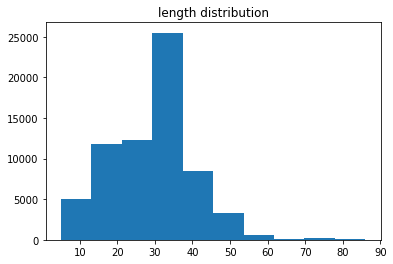

In [85]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# load data
def load_data():
    ben = []
    with open('benign-urls.txt','r') as f:
        for line in f:
            if not line.startswith('#'):
                ben.append(line.strip())
    mal =[]
    with open('malicious-urls.txt','r') as f:
        for line in f:
            mal.append(line.strip())
    # combine data create labels and shuffle data
    labels = [0]*len(ben)+[1]*len(mal)
    data = np.array([[text, l] for text, l in zip(ben+mal, labels)])
    np.random.shuffle(data)
    return list(data[:,0]), data[:,1]
X,y = load_data()
y = y.astype(int)
print('number of instances: ',len(X))
lengths = list(map(len, X))
plt.hist(lengths)
plt.title('length distribution')
plt.show()

In [86]:
train_X, test_X,train_y, test_y = train_test_split(X,y, test_size =0.3,random_state = 100 )

In [87]:
# create tokenization and character embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len = 55
char_dimension = 30
tok  = Tokenizer(char_level=True)
tok.fit_on_texts(train_X)
train_X_tok = tok.texts_to_sequences(train_X)
test_X_tok = tok.texts_to_sequences(test_X)
train_X_tok =pad_sequences(train_X_tok, maxlen =max_len)
test_X_tok = pad_sequences(test_X_tok, maxlen = max_len)
num_char =len(tok.word_index)

### 3.1 RNN

In [88]:
from keras.layers import Embedding, Bidirectional, LSTM, GRU, SpatialDropout1D, Dropout, Dense, Conv1D, MaxPool1D, Flatten
from keras.models import Sequential

In [89]:
rnn = Sequential()
rnn.add( Embedding(num_char+1,char_dimension,input_length=max_len))
rnn.add(Bidirectional(LSTM(64,return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
rnn.add(Flatten())
rnn.add(Dense(1, activation='sigmoid'))
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 55, 30)            1200      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 55, 128)           48640     
_________________________________________________________________
flatten_5 (Flatten)          (None, 7040)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7041      
Total params: 56,881
Trainable params: 56,881
Non-trainable params: 0
_________________________________________________________________


In [90]:
rnn.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
rnn.fit(train_X_tok, train_y, epochs=3, batch_size=128, validation_split=0.3)

Train on 32981 samples, validate on 14136 samples
Epoch 1/3
32981/32981 [==============================] - 23s 693us/step - loss: 0.0924 - acc: 0.9802 - val_loss: 0.0510 - val_acc: 0.9814
Epoch 2/3
32981/32981 [==============================] - 22s 667us/step - loss: 0.0454 - acc: 0.9822 - val_loss: 0.0319 - val_acc: 0.9871
Epoch 3/3
32981/32981 [==============================] - 21s 644us/step - loss: 0.0296 - acc: 0.9869 - val_loss: 0.0251 - val_acc: 0.9881


In [93]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
rnn_pred =rnn.predict_classes(test_X_tok)
rnn_prob =rnn.predict_proba(test_X_tok)
print('Precision: ',precision_score(test_y, rnn_pred))
print('Recall: ',recall_score(test_y, rnn_pred))
print('F1: ',f1_score(test_y, rnn_pred))
print('ROC AUC: ',roc_auc_score(test_y, rnn_prob))

Precision:  0.6349514563106796
Recall:  0.8515625
F1:  0.7274749721913237
ROC AUC:  0.993601321933367


### 3.2 CNN

In [101]:
cnn = Sequential()
cnn.add(Embedding(num_char+1,char_dimension,input_length=max_len))
cnn.add(Conv1D(128,activation='relu', kernel_size=3,padding='valid'))
cnn.add(SpatialDropout1D(0.1))
cnn.add(MaxPool1D())
cnn.add(Conv1D(64,activation='relu', kernel_size=3,padding='valid'))
cnn.add(SpatialDropout1D(0.1))
cnn.add(MaxPool1D())
cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 55, 30)            1200      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 53, 128)           11648     
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 53, 128)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 26, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 64)            24640     
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 24, 64)            0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 12, 64)            0         
__________

In [102]:
cnn.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
cnn.fit(train_X_tok, train_y, epochs=3, batch_size=128, validation_split=0.3)

Train on 32981 samples, validate on 14136 samples
Epoch 1/3
32981/32981 [==============================] - 6s 185us/step - loss: 0.0945 - acc: 0.9794 - val_loss: 0.0531 - val_acc: 0.9814
Epoch 2/3
32981/32981 [==============================] - 5s 146us/step - loss: 0.0335 - acc: 0.9851 - val_loss: 0.0236 - val_acc: 0.9883
Epoch 3/3
32981/32981 [==============================] - 5s 156us/step - loss: 0.0220 - acc: 0.9890 - val_loss: 0.0223 - val_acc: 0.9884


In [105]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
cnn_pred =cnn.predict_classes(test_X_tok)
cnn_prob =cnn.predict_proba(test_X_tok)
print('CNN performance:')
print('Precision: ',precision_score(test_y, cnn_pred))
print('Recall: ',recall_score(test_y,cnn_pred))
print('F1: ',f1_score(test_y, cnn_pred))
print('ROC AUC: ',roc_auc_score(test_y, cnn_prob))
print('\n====================================\n')
print('RNN performance')
print('Precision: ',precision_score(test_y, rnn_pred))
print('Recall: ',recall_score(test_y, rnn_pred))
print('F1: ',f1_score(test_y, rnn_pred))
print('ROC AUC: ',roc_auc_score(test_y, rnn_prob))

CNN performance:
Precision:  0.7107231920199502
Recall:  0.7421875
F1:  0.7261146496815287
ROC AUC:  0.9953531202675417


RNN performance
Precision:  0.6349514563106796
Recall:  0.8515625
F1:  0.7274749721913237
ROC AUC:  0.993601321933367


In [106]:
# malware proportion
y.mean()

0.019253910950661854

### Summary
We compared an rnn model with 64 bidirectional lstm units and a cnn model with two convoluiton layers with 128 and 64 filters respectively. Both models are layered on an character embedding with 40 characters and 55 dimensions and are trained for 3 epochs. The resulting models has similar trainable parameters. CNN model has much better precision than RNN model, yet RNN model has wins recall. The ROC AUC are high for both model due to imbalanced class size. In terms of training time, the CNN model trains almost 4 times faster than RNN model.